In [1]:
# Dataset name: Gearbox Fault Diagnosis Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
broken_dataset_url = "https://raw.githubusercontent.com/CS-Chinmay10/DMMS_Gearbox-fault-diagnosis-dataset/main/broken/b30hz50.csv"
healthy_dataset_url = "https://raw.githubusercontent.com/CS-Chinmay10/DMMS_Gearbox-fault-diagnosis-dataset/main/healthy/h30hz50.csv"

In [4]:
broken_df = pd.read_csv(broken_dataset_url, header=0)
healthy_df = pd.read_csv(healthy_dataset_url, header=0)
broken_df["applied_load"] = 50 * np.ones((broken_df.shape[0], 1))
healthy_df["applied_load"] = 50 * np.ones((healthy_df.shape[0], 1))

In [5]:
broken_df

,a1,a2,a3,a4,applied_load
0,-3.93468,6.55216,-1.237980,20.310300,50.0
1,2.40285,9.99438,-3.242650,8.313200,50.0
2,6.24273,-3.17577,-0.686974,-4.193820,50.0
3,-3.99411,-14.14480,3.845360,-5.658600,50.0
4,1.76551,-6.46492,5.096230,-9.001360,50.0
...,...,...,...,...,...
94203,-1.46153,2.78470,-1.151670,-4.537800,50.0
94204,-3.87952,0.85365,6.423880,-5.474920,50.0
94205,1.73315,4.06958,5.364500,0.216419,50.0
94206,8.97857,10.06520,1.552720,3.656620,50.0


In [6]:
healthy_df

,a1,a2,a3,a4,applied_load
0,2.144160,-1.958210,-0.190533,-4.584750,50.0
1,-9.920150,-7.475190,1.794680,-7.472510,50.0
2,-1.330590,0.751472,-3.557400,0.328149,50.0
3,7.761710,-1.498460,-1.764630,10.991900,50.0
4,-0.714011,-0.164771,9.650560,8.970950,50.0
...,...,...,...,...,...
110843,3.245040,-2.692110,2.714350,-0.639589,50.0
110844,1.347960,-2.303540,2.583290,-1.174450,50.0
110845,0.003272,-3.241480,-1.423700,-0.610475,50.0
110846,-0.031329,-3.361870,-1.493090,-2.147170,50.0


In [7]:
# Export to csv
healthy_df.to_csv("h50_data.csv", index=False)
broken_df.to_csv("b50_data.csv", index=False)

In [8]:
# Check to see if there are any null values.
print(healthy_df.isna().sum())

a1              0
a2              0
a3              0
a4              0
applied_load    0
dtype: int64


In [9]:
print(broken_df.isna().sum())

a1              0
a2              0
a3              0
a4              0
applied_load    0
dtype: int64


In [10]:
# Visualize correlation in the dataset.
corr = healthy_df.corr()
corr.style.background_gradient(cmap="coolwarm")     # Healthy 

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,a1,a2,a3,a4,applied_load
a1,1.000000,-0.033382,-0.072445,0.148111,nan
a2,-0.033382,1.000000,-0.228943,0.300243,nan
a3,-0.072445,-0.228943,1.000000,-0.126441,nan
a4,0.148111,0.300243,-0.126441,1.000000,nan
applied_load,nan,nan,nan,nan,nan


In [11]:
corr2 = broken_df.corr()
corr2.style.background_gradient(cmap="coolwarm")    # Broken

,a1,a2,a3,a4,applied_load
a1,1.000000,-0.314108,-0.011019,-0.197977,nan
a2,-0.314108,1.000000,-0.254381,0.289166,nan
a3,-0.011019,-0.254381,1.000000,-0.072557,nan
a4,-0.197977,0.289166,-0.072557,1.000000,nan
applied_load,nan,nan,nan,nan,nan


In [12]:
!pip install tsfel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 1.6 MB 7.6 MB/s 


In [13]:
import tsfel

In [14]:
cfg_file = tsfel.get_features_by_domain()

In [15]:
main_df_healthy = tsfel.time_series_features_extractor(cfg_file, healthy_df[["a1", "a2", "a3", "a4"]], fs=30, window_size=20)

*** Feature extraction started ***



*** Feature extraction finished ***


In [16]:
main_df_healthy["failure_label"] = np.zeros((main_df_healthy.shape[0], 1))  # Add label at end of df.

In [17]:
main_df_healthy.shape

(5542, 581)

In [18]:
main_df_broken = tsfel.time_series_features_extractor(cfg_file, broken_df[["a1", "a2", "a3", "a4"]], fs=30, window_size=20)

*** Feature extraction started ***



*** Feature extraction finished ***


In [19]:
main_df_broken["failure_label"] = np.ones((main_df_broken.shape[0], 1))

In [20]:
main_df_broken.shape

(4710, 581)

In [21]:
# Combine both main_df into final_df.
final_df = pd.concat([main_df_healthy, main_df_broken], axis=0, ignore_index=True)
final_df.to_csv("final_df.csv", index=False)

In [22]:
# Splitting the dataset into train and test set.
from sklearn.model_selection import train_test_split

In [23]:
X = final_df.drop("failure_label", axis=1)
y = final_df.failure_label

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

In [25]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (7176, 580)
Shape of X_test: (3076, 580)


In [27]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [28]:
scaler.fit(X_train)

StandardScaler()

In [29]:
scaled_X_train_df = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

In [30]:
# Extract the best features from the entire feature set.
x1 = X
y = final_df.failure_label
df_correlated_features = tsfel.correlated_features(x1)
x1.drop(df_correlated_features, axis=1, inplace=True)
print("Shape of x1:", x1.shape)

Shape of x1: (10252, 399)


In [31]:
# Using ML to extract the best features.
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold

In [32]:
rfecv = RFECV(estimator=SVC(kernel="linear"), step=1, cv=StratifiedKFold(4),
              scoring="accuracy")

In [33]:
rfetrain = rfecv.fit(x1, y)

In [34]:
print("Number of optimal features:", rfecv.n_features_)

Number of optimal features: 68


In [35]:
# Exporting the optimal features as a csv file for later use.
selected_features = x1.iloc[:, rfecv.support_]
selected_features.to_csv("optimal_final_df.csv", index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


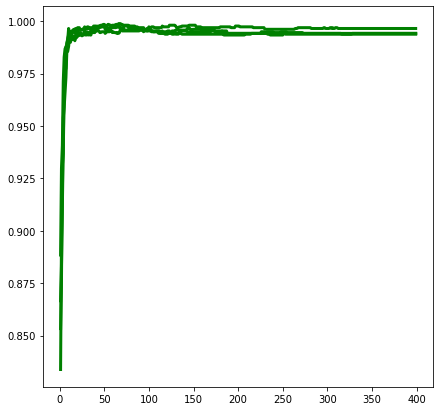

In [37]:
# Plot for RFECV
fig, axes = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)

axes.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 
          color="green", linewidth=3)
plt.show()

In [ ]:
# Start building the classification model.

In [54]:
optimal_df_url = "https://raw.githubusercontent.com/CS-Chinmay10/DMMS_Gearbox-fault-diagnosis-dataset/main/optimal_final_df.csv"

In [55]:
optimal_df = pd.read_csv(optimal_df_url, header=0)  # Contains only features
optimal_df.reset_index(inplace=True, drop=True)

In [56]:
y = final_df.failure_label  # Label: 0 - Healthy, 1 - BrokenTooth

In [57]:
X_train_optimal, X_test_optimal, y_train_optimal, y_test_optimal = train_test_split(
    optimal_df, y, test_size=0.3, random_state=100
)

In [59]:
# Apply feature scaling
scaler1 = StandardScaler()

In [60]:
scaler1.fit(X_train_optimal)

StandardScaler()

In [61]:
scaled_X_train_optimal = pd.DataFrame(scaler1.transform(X_train_optimal), columns=X_train_optimal.columns)

In [63]:
scaled_X_test_optimal = pd.DataFrame(scaler1.transform(X_test_optimal), columns=X_test_optimal.columns)

In [67]:
scaled_X_train_optimal.head()

,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_Histogram_2,0_Histogram_5,0_Histogram_8,0_LPCC_6,0_Mean absolute diff,...,3_Histogram_7,3_LPCC_0,3_LPCC_1,3_Mean absolute diff,3_Median absolute diff,3_Spectral kurtosis,3_Spectral skewness,3_Wavelet energy_2,3_Wavelet energy_3,3_Zero crossing rate
0,1.937855,0.775222,-0.207503,-0.021783,-0.354873,-0.547282,-0.550943,-0.534645,-1.221192,0.878755,...,-0.623177,-1.164132,-1.655143,2.478377,3.213810,-0.915064,-2.187701,1.366079,1.971370,1.716527
1,2.463975,0.046537,-0.452737,-0.496094,-0.505065,-0.547282,-0.550943,-0.534645,-0.180890,-0.798341,...,-0.623177,-0.019909,1.943159,-0.250521,0.054151,3.071223,2.715172,1.700520,1.340225,-0.881726
2,-0.601632,-0.674382,-0.535537,-0.465822,-0.126242,2.903769,-0.550943,3.035955,0.162368,-0.776520,...,0.875455,-0.311002,1.232178,-1.503545,-1.359160,1.053828,2.088573,-0.627637,-0.297449,0.677226
3,7.173622,7.435461,-0.313966,-0.395136,-0.503304,-0.547282,-0.550943,-0.534645,-0.951640,0.055176,...,-0.623177,-0.721595,0.448687,1.094166,1.006079,0.812997,0.470869,0.986943,1.298572,-0.362075
4,-0.634001,0.570619,-0.556254,-0.515678,-0.502625,-0.547282,-0.550943,-0.534645,0.011483,-0.481187,...,-0.623177,-0.401030,-0.728905,-0.728026,-0.824544,-1.299975,-1.161763,-1.156642,-1.045322,1.196876


In [68]:
scaled_X_test_optimal.head()

,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_Histogram_2,0_Histogram_5,0_Histogram_8,0_LPCC_6,0_Mean absolute diff,...,3_Histogram_7,3_LPCC_0,3_LPCC_1,3_Mean absolute diff,3_Median absolute diff,3_Spectral kurtosis,3_Spectral skewness,3_Wavelet energy_2,3_Wavelet energy_3,3_Zero crossing rate
0,-0.615865,-0.564857,0.518000,-0.485667,-0.397379,-0.547282,-0.550943,-0.534645,0.707769,-0.824965,...,-0.623177,-0.374995,0.638113,-0.902547,-1.079842,-0.731382,-0.019261,-0.587512,-0.559209,0.157575
1,-0.694057,-0.541895,-0.369317,-0.496068,0.063937,-0.547282,-0.550943,-0.534645,-0.069631,-0.430262,...,-0.623177,-1.213049,0.694857,-0.855896,-0.919459,0.140002,1.093993,-0.190553,-0.332912,-0.881726
2,-0.675247,0.469088,1.679617,-0.246453,-0.430847,-0.547282,-0.550943,-0.534645,1.880417,1.786035,...,-0.623177,1.562603,-0.884865,0.989423,0.940755,-0.511964,-0.653537,0.537631,0.790927,1.196876
3,0.304504,-0.401686,-0.559494,0.414535,0.318229,-0.547282,1.156124,-0.534645,0.315604,1.086893,...,-0.623177,-0.558536,1.239462,-0.936759,-0.801150,2.679604,3.143983,2.601544,3.533628,-1.401376
4,-0.297214,-0.415561,1.150910,-0.421528,-0.405975,1.178244,-0.550943,-0.534645,1.951621,-0.451138,...,2.374086,-0.637068,-0.702485,-0.228921,-0.425670,0.139364,0.290972,-0.559803,-1.058349,-0.362075


In [69]:
# Building ML models

In [74]:
# Model 1: Support Vector Classifier - using linear kernel
lin_clf = SVC(kernel="linear", random_state=100)
lin_clf.fit(scaled_X_train_optimal, y_train)

SVC(kernel='linear', random_state=100)

In [75]:
# Generate predictions for test set.
lin_clf_preds = lin_clf.predict(scaled_X_test_optimal)

In [140]:
# Assess the accuracy score obtained on test set.
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report, precision_score

In [143]:
lin_acc_score = accuracy_score(y_test, lin_clf_preds)
print(lin_acc_score)

0.997074122236671


In [144]:
# Precision score
lin_prec_score = precision_score(y_test, lin_clf_preds)
print(lin_prec_score)

0.9944367176634215


In [145]:
# Confusion matrix
print(confusion_matrix(y_test, lin_clf_preds))

[[1637    8]
 [   1 1430]]


In [146]:
# f1_score
lin_f1_score = f1_score(y_test, lin_clf_preds)
print(lin_f1_score)

0.9968630184733357


In [147]:
# Recall score
lin_recall_score = recall_score(y_test, lin_clf_preds)
print(lin_recall_score)

0.9993011879804332


In [148]:
# Classification report
print(classification_report(y_test, lin_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.99939   0.99514   0.99726      1645
         1.0    0.99444   0.99930   0.99686      1431

    accuracy                        0.99707      3076
   macro avg    0.99691   0.99722   0.99706      3076
weighted avg    0.99709   0.99707   0.99707      3076



In [97]:
# Model 2: Support Vector Classifier - using rbf kernel
rbf_clf = SVC(kernel="rbf", random_state=100)

In [98]:
# Training
rbf_clf.fit(scaled_X_train_optimal, y_train)

SVC(random_state=100)

In [99]:
# Generate predictions for test set.
rbf_clf_preds = rbf_clf.predict(scaled_X_test_optimal)

In [149]:
# Assess the accuracy score obtained on test set.
rbf_acc_score = accuracy_score(y_test, rbf_clf_preds)
print(rbf_acc_score)

0.9931729518855656


In [151]:
# Precision score
rbf_prec_score = precision_score(y_test, rbf_clf_preds)
print(rbf_prec_score)

0.9889042995839112


In [152]:
# Confusion matrix
print(confusion_matrix(y_test, rbf_clf_preds))

[[1629   16]
 [   5 1426]]


In [153]:
# f1_score
rbf_f1_score = f1_score(y_test, rbf_clf_preds)
print(rbf_f1_score)

0.9926905673512009


In [154]:
# Recall score
rbf_recall_score = recall_score(y_test, rbf_clf_preds)
print(rbf_recall_score)

0.9965059399021663


In [155]:
# Classification report
print(classification_report(y_test, rbf_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.99694   0.99027   0.99360      1645
         1.0    0.98890   0.99651   0.99269      1431

    accuracy                        0.99317      3076
   macro avg    0.99292   0.99339   0.99314      3076
weighted avg    0.99320   0.99317   0.99317      3076



In [105]:
# Model 3: Neural Network Implementation
from sklearn.neural_network import MLPClassifier

In [106]:
nn_clf = MLPClassifier(max_iter=1000, random_state=100)

In [107]:
nn_clf.fit(scaled_X_train_optimal, y_train)

MLPClassifier(max_iter=1000, random_state=100)

In [108]:
# Generate predictions for test set.
nn_clf_preds = nn_clf.predict(scaled_X_test_optimal)

In [156]:
# Assess the accuracy score obtained on test set.
nn_acc_score = accuracy_score(y_test, nn_clf_preds)
print(nn_acc_score)

0.9960988296488946


In [157]:
# Precision score
nn_prec_score = precision_score(y_test, nn_clf_preds)
print(nn_prec_score)

0.9937369519832986


In [158]:
# Confusion matrix
print(confusion_matrix(y_test, nn_clf_preds))

[[1636    9]
 [   3 1428]]


In [159]:
# f1_score
nn_f1_score = f1_score(y_test, nn_clf_preds)
print(nn_f1_score)

0.9958158995815899


In [160]:
# Recall score
nn_recall_score = recall_score(y_test, nn_clf_preds)
print(nn_recall_score)

0.9979035639412998


In [161]:
# Classification report
print(classification_report(y_test, nn_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.99817   0.99453   0.99635      1645
         1.0    0.99374   0.99790   0.99582      1431

    accuracy                        0.99610      3076
   macro avg    0.99595   0.99622   0.99608      3076
weighted avg    0.99611   0.99610   0.99610      3076



In [119]:
# Model 4: Decision Tree Classification
from sklearn.tree import DecisionTreeClassifier

In [132]:
dtc_clf = DecisionTreeClassifier(criterion="entropy")

In [133]:
dtc_clf.fit(scaled_X_train_optimal, y_train)

DecisionTreeClassifier(criterion='entropy')

In [134]:
# Generate predictions for test set.
dtc_clf_preds = dtc_clf.predict(scaled_X_test_optimal)

In [162]:
# Assess the accuracy score obtained on test set.
dtc_acc_score = accuracy_score(y_test, dtc_clf_preds)
print(dtc_acc_score)

0.9788686605981795


In [183]:
# Precision score
dtc_prec_score = precision_score(y_test, dtc_clf_preds)
print(dtc_prec_score)

0.9756267409470752


In [184]:
# Confusion matrix
print(confusion_matrix(y_test, dtc_clf_preds))

[[1610   35]
 [  30 1401]]


In [185]:
# f1_score
dtc_f1_score = f1_score(y_test, dtc_clf_preds)
print(dtc_f1_score)

0.9773282176491106


In [186]:
# Recall score
dtc_recall_score = recall_score(y_test, dtc_clf_preds)
print(dtc_recall_score)

0.9790356394129979


In [187]:
# Classification report
print(classification_report(y_test, dtc_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.98171   0.97872   0.98021      1645
         1.0    0.97563   0.97904   0.97733      1431

    accuracy                        0.97887      3076
   macro avg    0.97867   0.97888   0.97877      3076
weighted avg    0.97888   0.97887   0.97887      3076



In [188]:
# Graphical representation of different model performance.
lin_performance_data = [lin_acc_score, lin_prec_score, lin_recall_score, lin_f1_score]
rbf_performance_data = [rbf_acc_score, rbf_prec_score, rbf_recall_score, rbf_f1_score]
nn_performance_data = [nn_acc_score, nn_prec_score, nn_recall_score, nn_f1_score]
dtc_performance_data = [dtc_acc_score, dtc_prec_score, dtc_recall_score, dtc_f1_score]


In [209]:
performance_df = pd.DataFrame([lin_performance_data, rbf_performance_data, nn_performance_data, dtc_performance_data],
                       columns=["Accuracy", "Precision", "Recall", "F1"],
                       index=["SVC Linear Kernel", "SVC RBF Kernel", "MLPClassifier", "Decision Tree Classifier"])

In [210]:
performance_df

,Accuracy,Precision,Recall,F1
SVC Linear Kernel,0.997074,0.994437,0.999301,0.996863
SVC RBF Kernel,0.993173,0.988904,0.996506,0.992691
MLPClassifier,0.996099,0.993737,0.997904,0.995816
Decision Tree Classifier,0.978869,0.975627,0.979036,0.977328
